### Exercises

#### CRUD operations:


**TODO 1**: You will continue to work on the MCU network for a while. Who are the 10 fastest in the MCU ? Are they related to each other ?


In [38]:
import pandas as pd
from py2neo import Graph, Node, Relationship

characters_csv = "/Users/valen/Desktop/data/Chap4/Marvel_Superheroes/characters.csv"
characters_stats_csv = "/Users/valen/Desktop/data/Chap4/Marvel_Superheroes/characters_stats.csv"
characters2comics_csv = "/Users/valen/Desktop/data/Chap4/Marvel_Superheroes/charactersToComics.csv"

characters = pd.read_csv(characters_csv)
characters_stats = pd.read_csv(characters_stats_csv)
characters2comics = pd.read_csv(characters2comics_csv)


In [59]:
characters_stats

,Name,Alignment,Intelligence,Strength,Speed,Durability,Power,Combat,Total
0,3-D Man,good,50,31,43,32,25,52,233
1,A-Bomb,good,38,100,17,80,17,64,316
2,Abe Sapien,good,88,14,35,42,35,85,299
3,Abin Sur,good,50,90,53,64,84,65,406
4,Abomination,bad,63,80,53,90,55,95,436
...,...,...,...,...,...,...,...,...,...
606,Yellowjacket,good,88,10,12,28,12,14,164
607,Yellowjacket II,good,50,10,35,28,31,28,182
608,Ymir,good,50,100,27,100,83,28,388
609,Zatanna,good,75,10,23,28,100,56,292


In [32]:
import pandas as pd
import tqdm
import py2neo

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"))

graph.delete_all()

try:
    graph.run("CREATE CONSTRAINT ON (n:Superhero) ASSERT n.id_ IS UNIQUE")
except:
    print("Constraint already exists")


transaction_list = []

for row in tqdm.tqdm(characters.iterrows()):
    id_ = row[1]["characterID"]
    name = row[1]["name"]
    transaction_list.append({"id_":id_,"name":name})
    if len(transaction_list) == 1000:
        transaction = "UNWIND $json as data CREATE (n:Superhero) SET n = data"
        graph.run(transaction, json=transaction_list)
        transaction_list = []

graph.run(transaction, json=transaction_list)

pass

Constraint already exists


1170it [00:00, 6594.16it/s]


In [35]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"))

transaction = """UNWIND $json as data
OPTIONAL MATCH (a:Superhero {name:data.Name})
SET a += {Alignement:data.Alignement,Intelligence:data.Intelligence,Strength:data.Strength,Speed:data.Speed,Durability:data.Durability,
         Power:data.Power,Combat:data.Combat,Total:data.Total} 
"""

transaction_list = []

iteration = 0
for row in tqdm.tqdm(characters_stats.iterrows()):
    transaction_list.append(dict(row[1]))
    iteration += 1
    if iteration % 1000 == 0:
        graph.run(transaction, json=transaction_list)
        transaction_list = []
        
graph.run(transaction, json=transaction_list)

pass

0it [00:00, ?it/s]

611it [00:00, 17057.85it/s]


In [41]:
import pandas as pd
import tqdm
import py2neo
import itertools

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"))

characters2comics = characters2comics.drop_duplicates()
transaction_list = []

transaction = """UNWIND $json as data
MATCH (a:Superhero),(b:Superhero)
WHERE a.id_ = data.id_1 AND b.id_ = data.id_2
MERGE (a)-[r:RELATION]->(b)
ON CREATE
    SET r.n_collab = 1
ON MATCH
    SET r.n_collab = r.n_collab + 1
"""

it = 0   
for comic in tqdm.tqdm(characters2comics.groupby(["comicID"])):
    related_ids = comic[1]["characterID"]
    for combi in list(itertools.combinations(related_ids, 2)):
        sh1 = combi[0]
        sh2 = combi[1]
        transaction_list.append({"id_1":sh1,"id_2":sh2})
        it +=1
        if it % 1000 == 0:
            graph.run(transaction, json=transaction_list)
            transaction_list = []

graph.run(transaction, json=transaction_list)
pass

100%|██████████| 22250/22250 [05:04<00:00, 73.01it/s] 


In [42]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"))

query = """MATCH (a:Superhero{name:'Pepper Potts'})-[r:RELATION]-(b:Superhero{name:'Iron Man'}) RETURN r,a,b"""
data = graph.run(query).to_data_frame()
print(data["r"],data["a"],data["b"])

0    {'n_collab': 68}
Name: r, dtype: object 0    {'id_': 1009494, 'name': 'Pepper Potts'}
Name: a, dtype: object 0    {'Speed': 58, 'Intelligence': 100, 'id_': 1009...
Name: b, dtype: object


In [53]:
#Who are the 10 fastest in the MCU ?
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"))


query = """
MATCH (c:Superhero)
WHERE c.Speed IS NOT NULL
RETURN c.name AS name, c.Speed AS speed
ORDER BY c.Speed DESC
LIMIT 10
"""

fastest_names = graph.run(query).to_data_frame()
fastest_names


,name,speed
0,Black Bolt,100
1,Stardust,100
2,Quicksilver,100
3,Nova,100
4,Thor,92
5,Silver Surfer,84
6,Galactus,83
7,Dormammu,83
8,Ego,83
9,Northstar,83


In [55]:

fastest_characters = graph.run(query).data()
fastest_names = [char['name'] for char in fastest_characters]

query_relationships = """
MATCH (c1:Superhero)-[r]-(c2:Superhero)
WHERE c1.name IN $names AND c2.name IN $names
RETURN c1.name AS source, c2.name AS target, type(r) AS relationship
"""

relationships = graph.run(query_relationships, names=fastest_names).data()

for rel in relationships:
    print(f"{rel['source']} is related to {rel['target']} via {rel['relationship']}")


Galactus is related to Ego via RELATION
Galactus is related to Dormammu via RELATION
Galactus is related to Black Bolt via RELATION
Galactus is related to Northstar via RELATION
Galactus is related to Nova via RELATION
Galactus is related to Stardust via RELATION
Galactus is related to Silver Surfer via RELATION
Galactus is related to Quicksilver via RELATION
Galactus is related to Thor via RELATION
Silver Surfer is related to Ego via RELATION
Silver Surfer is related to Nova via RELATION
Silver Surfer is related to Quicksilver via RELATION
Silver Surfer is related to Black Bolt via RELATION
Silver Surfer is related to Galactus via RELATION
Silver Surfer is related to Dormammu via RELATION
Silver Surfer is related to Stardust via RELATION
Silver Surfer is related to Thor via RELATION
Thor is related to Northstar via RELATION
Thor is related to Ego via RELATION
Thor is related to Silver Surfer via RELATION
Thor is related to Nova via RELATION
Thor is related to Black Bolt via RELATION
T

In [57]:
#Produisons une matrice pour observons les relations
matrix = pd.DataFrame(0, index=fastest_names, columns=fastest_names)

for rel in relationships:
    matrix.at[rel['source'], rel['target']] = 1
    matrix.at[rel['target'], rel['source']] = 1  

matrix

,Black Bolt,Stardust,Quicksilver,Nova,Thor,Silver Surfer,Galactus,Dormammu,Ego,Northstar
Black Bolt,0,0,1,1,1,1,1,0,0,0
Stardust,0,0,0,0,0,1,1,0,0,0
Quicksilver,1,0,0,1,1,1,1,1,1,1
Nova,1,0,1,0,1,1,1,0,1,0
Thor,1,0,1,1,0,1,1,1,1,1
Silver Surfer,1,1,1,1,1,0,1,1,1,0
Galactus,1,1,1,1,1,1,0,1,1,1
Dormammu,0,0,1,0,1,1,1,0,0,0
Ego,0,0,1,1,1,1,1,0,0,0
Northstar,0,0,1,0,1,0,1,0,0,0


**TODO 2**: How many have collaborated atleast more than 10 times with another superhero?



In [58]:
query = """
MATCH (c1:Superhero)-[r:RELATION]-(c2:Superhero)
RETURN count(DISTINCT c1.id_ + c2.id_) AS collaboration_count
"""

collaboration_count = graph.run(query).evaluate()
collaboration_count

4907

**TODO 3**: Did the weakest of the MCU collaborated with the strongest ?


In [66]:
#Pour déterminer le "strongest" nous nous baserons sur la caractéristique "Strength", nous pourrions cependant tout aussi bien nous
#intéressé à la somme des caractéristiques du perso.
query_strength = """
MATCH (c:Superhero)
WHERE c.Strength IS NOT NULL
RETURN c.name AS name, c.Strength AS strength
ORDER BY c.Strength DESC
LIMIT 1
"""

query_weakest = """
MATCH (c:Superhero)
WHERE c.Strength IS NOT NULL
RETURN c.name AS name, c.Strength AS strength
ORDER BY c.Strength ASC
LIMIT 1
"""

strongest_character = graph.run(query_strength).evaluate('name')
weakest_character = graph.run(query_weakest).evaluate('name')

query_collaboration = """
MATCH (c1:Superhero)-[r:RELATION]-(c2:Superhero)
WHERE c1.name = $strongest AND c2.name = $weakest
RETURN count(r) > 0 AS collaborated
"""

collaborated = graph.run(query_collaboration, strongest=strongest_character, weakest=weakest_character).evaluate()
print(strongest_character)
print(weakest_character)
print(collaborated)


Galactus
Lady Deathstrike
False


        -> Non le plus fort et le plus faible n'ont pas collaboré ensemble

**TODO 4**: Give a stats that interests you !


Nous allons nous intéresser au perso ayant les stats les plus polyvalentes du MCU. Pour ce faire, nous allons étudier le coefficient de variation tq CV= 
σ/μ
​
, le perso ayant le plus bas score de coefficient de variation sera alors le plus polyvalent.

In [72]:

query_stats = """
MATCH (c:Superhero)
RETURN c.name AS name, c.Intelligence AS Intelligence, c.Strength AS Strength, 
       c.Speed AS Speed, c.Durability AS Durability, c.Power AS Power, 
       c.Combat AS Combat, c.Total AS Total
"""

data = graph.run(query_stats).to_data_frame()


data['CV'] = data[['Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat']].std(axis=1) / data[['Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat']].mean(axis=1)

most_versatile = data.sort_values('CV').iloc[0]
most_versatile


name            Dormammu
Intelligence        88.0
Strength            95.0
Speed               83.0
Durability         100.0
Power              100.0
Combat              80.0
Total              546.0
CV              0.094786
Name: 130, dtype: object

**TODO 5**: Create a new db called "master". Create a graph from the M1 class with name and random age between 20 and 30, Group of 3 that collab (undirected relation).


**TODO 6**: Get the age for people YOU collaborate with.


**TODO 7**: Get nodes with age > 25.

### Real world problem:

**TODO 8**: Using the downloaded data in TODO 11 of chapter II, create a collaboration network between authors for papers after 2021 (same author if same name). Insert it in neo4j in a db called "arxiv".

**TODO 9**: Get the density of degrees of the collaboration network

**TODO 10**: Do a for loop for i in range(500) for each i remove nodes with a degree less than i.

### Homework 3

You will work again on [pubmed_last_100k.json](https://we.tl/t-6afLCDGRsg). The goal in this homework is to insert collaboration data in Neo4j and then study it using cypher queries. The following questions are meant to guide you through the process.

1) Each paper has a list of author and affiliations. The first step is to create a node per author with a list of affiliation as attribute. If a name appears multiple times consider it as a single person. Create an edge between two authors if they are on the same paper. You can use any kind of operation to clean the data before inserting, you decide which preprocessing step is the most convenient.

In [2]:
import json
import re
from py2neo import Graph

graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"))

json_fp = "/Users/valen/Desktop/data/Chap3/pubmed_cleaned/pubmed_cleaned.json"
with open(json_fp, "r") as file:
    data = json.load(file)

for entry in data:
    title = entry['title']
    authors_affiliations = re.findall(r'name ml (.*?), affil str (.*?)\.', entry['authors'])

    for i in range(len(authors_affiliations)):
        author1, affiliation1 = authors_affiliations[i]

        graph.run(
            "MERGE (a:Author {name: $name}) "
            "SET a.affiliations = COALESCE(a.affiliations, []) + [$affiliation]",
            name=author1, affiliation=affiliation1
        )

        for j in range(i + 1, len(authors_affiliations)):
            author2, affiliation2 = authors_affiliations[j]

            graph.run(
                "MERGE (b:Author {name: $name}) "
                "SET b.affiliations = COALESCE(b.affiliations, []) + [$affiliation]",
                name=author2, affiliation=affiliation2
            )

            graph.run(
                "MATCH (a:Author {name: $name1}), (b:Author {name: $name2}) "
                "MERGE (a)-[:SAME_TITLE]->(b)",
                name1=author1, name2=author2
            )

KeyboardInterrupt: 

        -> Après près de 1min30 de chargement j'ai cut, nous exécuterons les questions suivantes avec le peu de données que nous possédons, risquant de ne pas avoir les bons output

2) How many authors have more than 2 affiliations ?

In [4]:
from py2neo import Graph

result = graph.run(
    "MATCH (a:Author) "
    "WHERE size(a.affiliations) > 2 "
    "RETURN count(a) AS authors_with_more_than_two_affiliations"
)

count_result = result.next()
if count_result:
    count = count_result["authors_with_more_than_two_affiliations"]
    print(f"Number of authors with more than 2 affiliations: {count}")
else:
    print("No result found.")


Number of authors with more than 2 affiliations: 8316


3) Create a density of node degrees. Do you observe a power scale law ? What does it mean ?


In [5]:
import matplotlib.pyplot as plt
from collections import Counter

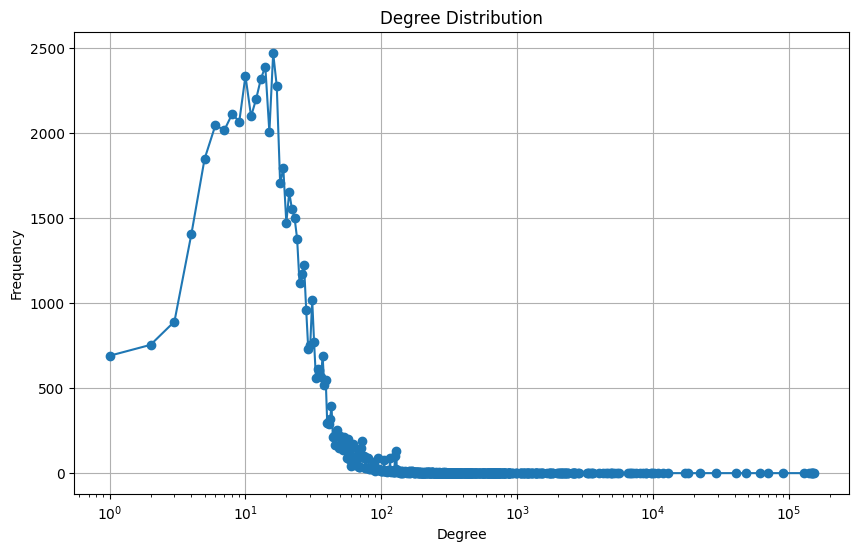

In [24]:
query = """
MATCH (n:Author)-[r]-()
RETURN n.name AS author, count(r) AS degree
"""

degrees = [record['degree'] for record in graph.run(query)]

degree_counts = Counter(degrees)

x, y = zip(*sorted(degree_counts.items()))

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.xscale('log')
plt.title("Degree Distribution")
plt.grid(True)
plt.show()

        -> Nous observons plutôt une distribution binomiale négative au vu du sommet de la cloche en 10 du fait que la grand majorité des articles aient peu d'auteurs tandis que les papiers ayant le plus d'auteurs se font rare. Ce résultat est logique.

4) Which country has seen the most international collaboration ?

In [7]:
result = graph.run(
    "MATCH (a:Author)-[:SAME_TITLE]-(b:Author) "
    "WHERE size([aff IN a.affiliations WHERE aff =~ '.*, [A-Z]{2,}' ]) > 0 "
    "AND size([aff IN b.affiliations WHERE aff =~ '.*, [A-Z]{2,}' ]) > 0 "
    "AND ANY(aff1 IN a.affiliations WHERE ANY(aff2 IN b.affiliations WHERE aff1 <> aff2)) "
    "WITH last(split(head([aff IN a.affiliations WHERE aff =~ '.*, [A-Z]{2,}' ]), ',')) AS country1, "
    "     last(split(head([aff IN b.affiliations WHERE aff =~ '.*, [A-Z]{2,}' ]), ',')) AS country2 "
    "WHERE country1 <> country2 "
    "RETURN country1 AS country, COUNT(*) AS collaborations "
    "ORDER BY collaborations DESC "
    "LIMIT 1"
)

result.data()

[{'country': ' USA', 'collaborations': 15180}]

5) Who are the top 10 collaborators and what is their affiliation ?

In [14]:
import pandas as pd 

result = graph.run(
    "MATCH (a:Author)-[r:SAME_TITLE]-(b:Author) "
    "WITH a, COUNT(r) AS collaborations "
    "ORDER BY collaborations DESC "
    "LIMIT 10 "
    "RETURN a.name AS author_name, a.affiliations AS affiliations, collaborations"
)

data = result.data()
df = pd.DataFrame(data)
df


,author_name,affiliations,collaborations
0,Tirant M,"[University of Rome G, University of Rome G, U...",6044
1,Tirant M,"[University of Rome G, University of Rome G, U...",6041
2,Tirant M,"[University of Rome G, University of Rome G, U...",6024
3,Tirant M,"[University of Rome G, University of Rome G, U...",5997
4,Tirant M,"[University of Rome G, University of Rome G, U...",5960
5,Satolli F,"[Unit of Dermatology, University of Parma, Par...",5953
6,Vojvodic A,"[Department of Dermatology and Venereology, Mi...",5949
7,Satolli F,"[Unit of Dermatology, University of Parma, Par...",5947
8,Gandolfi M,"[Unit of Dermatology, University of Parma, Par...",5946
9,Vojvodic A,"[Department of Dermatology and Venereology, Mi...",5942



6) Sandbox exercise: think of a problematic and try to answer it.

        ->Déterminer les sujets de recherche les plus courants dans les documents de collaboration.

In [20]:
import pandas as pd
from py2neo import Graph
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"))

result = graph.run(
    "MATCH (a:Author)-[:SAME_TITLE]-(b:Author) "
    "WITH COLLECT(DISTINCT a) + COLLECT(DISTINCT b) AS authors "
    "UNWIND authors AS author "
    "RETURN DISTINCT author.title AS title"
)

data = result.data()
titles = [entry['title'] for entry in data if entry['title']]

tokens = []
for title in titles:
    words = word_tokenize(title.lower())
    filtered_words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and w.isalpha()]
    tokens.extend(filtered_words)

top_topics = Counter(tokens).most_common(10)

print("Top 10 Research Topics:")
for topic, freq in top_topics:
    print(f"{topic}: {freq}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valen\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\valen\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\valen\AppData\Roaming\nltk_data...


Top 10 Research Topics:
cell: 151
patient: 133
cancer: 120
study: 99
treatment: 91
effect: 89
disease: 87
using: 68
response: 68
new: 60


  -> Dans ce code nous avons utiliser une fonction classique pour rendre minuscule l'ensemble des mots, nous avons ensuite utilisé le package nltk pour procéder à une tokenisation pour fractionner le texte en mots. Nous avons retirer les mots courants (and, the, of, etc.) qui parasiterais les résultats et nous avons procédé à une Lemmatisation pour rendre uniformiser les mots et éviter d'avoir des mots à mêmes racines dans nos résultats. Suite à cela, nous avons compter les mots et obtenus les résultats ci-dessous, que nous allons représenter sous forme de fréquence dans un diagramme circulaire

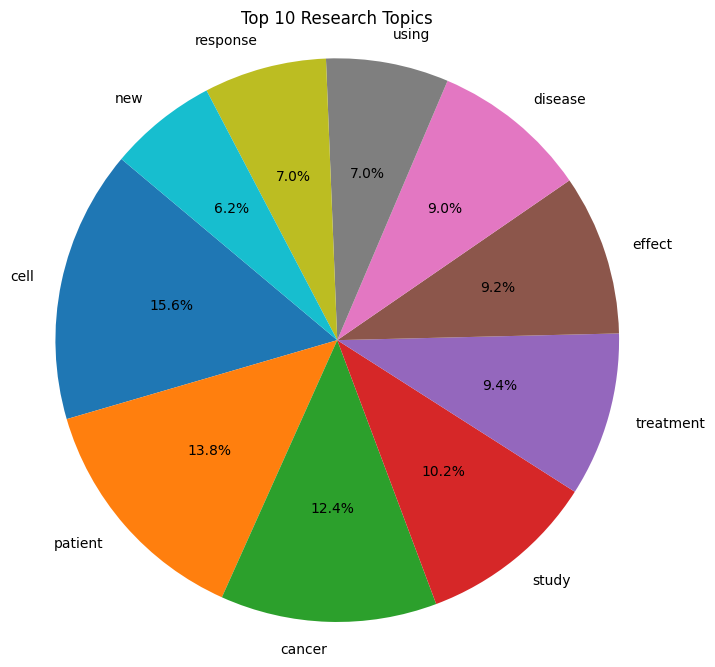

In [22]:
import matplotlib.pyplot as plt

labels, sizes = zip(*top_topics)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Research Topics')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.show()

### Homework 4

change the database "neo4j" to the database "movie". Go to the browser and run on the browser console :play movie-graph then copy the queries on the console and run it. Congrats you just imported a brand new sample of data. Answer the following questions with cypher queries.


1) How many actors played in more than 2 movie ? Get their names and year they were born.


2) In how many movies did Tom hanks play ?


3) In average in how many movies do actors play in ?

4) In average how many actors are there in a movie ?


5) In average how many writers is needed to write a movie ?


6) What is the proportion of writers that also directed the movie ?


7) Do an histogram of the year of release for the movies.


8) Who are the 10 actors with the most movie played in


9) Delete every movie made by a director of your choosing


10) Give some statistics that you find interesting.


11) Sandbox exercise: think of a problematic and try to answer it.

## Homework 5

You will work on a Twitch dataset found [here](https://www.kaggle.com/andreagarritano/twitch-social-networks). The goal is to learn more about the feat&fun on Twitch. First thing to do is create the network on Neo4j. Insert the node
from Twitch/FR_target and then the edges from Twitch/FR_edges.csv in neo4j. Answer the following using cypher queries


In [26]:
import pandas as pd
from py2neo import Graph, Node, Relationship

targets_fp = "/Users/valen/Desktop/data/Twitch/FR_target.csv"
edges_fp = "/Users/valen/Desktop/data/Twitch/FR_edges.csv"

target = pd.read_csv(targets_fp)
edges = pd.read_csv(edges_fp)

In [29]:
target

,id,days,mature,views,partner,new_id
0,150417538,577,True,775,False,4867
1,125723704,861,True,2585,False,3692
2,155971814,523,False,1566,False,3816
3,35832890,2234,False,9713,False,416
4,46787750,1896,True,44529,False,4502
...,...,...,...,...,...,...
6546,29196284,2061,False,3822,False,6546
6547,124327806,880,True,30313,False,2392
6548,144229380,640,True,5022,False,391
6549,131423064,736,False,2658,False,2793


In [30]:
edges

,from,to
0,0,6420
1,0,2941
2,0,3051
3,0,5511
4,0,1020
...,...,...
112661,77,6542
112662,6516,6527
112663,6520,6527
112664,6527,6542


In [29]:
from py2neo import Graph, Node, Relationship

graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name = "twitch")
graph.delete_all()

graph.run("CREATE INDEX FOR (u:TwitchUser) ON (u.id)")
graph.run("CREATE INDEX FOR (u:TwitchUser) ON (u.new_id)")

with open(targets_fp, 'r') as file:
    next(file) 
    nodes_batch = []
    for line in file:
        id, days, mature, views, partner, new_id = line.strip().split(',')  
        nodes_batch.append({"id": id, "days": days, "mature": mature, "views": views, "partner": partner, "new_id": new_id})
    
    graph.run(
        "UNWIND $nodes_batch AS row "
        "CREATE (:TwitchUser {id: row.id, days: row.days, mature: row.mature, views: row.views, partner: row.partner, new_id: row.new_id})",
        {"nodes_batch": nodes_batch}
    )

with open(edges_fp, 'r') as file:
    next(file)
    edges_batch = []
    for line in file:
        source_id, target_id = line.strip().split(',')
        edges_batch.append({"source_id": source_id, "target_id": target_id})
    
    graph.run(
        "UNWIND $edges_batch AS edge "
        "MATCH (source:TwitchUser {new_id: edge.source_id}) "
        "MATCH (target:TwitchUser {new_id: edge.target_id}) "
        "CREATE (source)-[:FOLLOWS]->(target)",
        {"edges_batch": edges_batch}
    )

1) Give the IDs of the top 10 streamers that have atleast one collaboration.


In [38]:
query = """
MATCH (streamer:TwitchUser)-[:FOLLOWS]->(:TwitchUser)
WITH streamer, count(*) AS collaborations
WHERE collaborations > 0
RETURN streamer.id AS streamer_id, collaborations
ORDER BY collaborations DESC
LIMIT 10
"""

graph.run(query).to_data_frame()

,streamer_id,collaborations
0,28575692,1491
1,41719107,1393
2,24147592,1350
3,89872865,673
4,4102418,656
5,42141251,615
6,84934385,611
7,135468063,560
8,40063341,549
9,30709418,511


2) Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

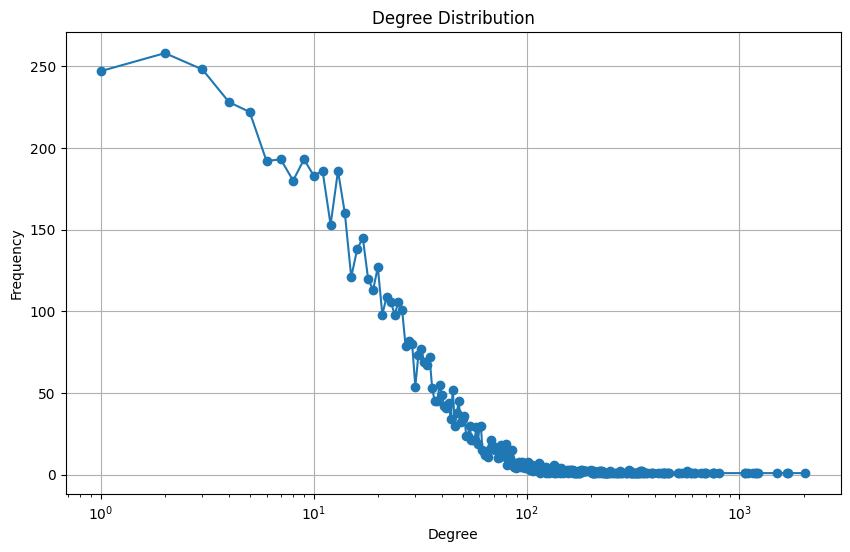

In [30]:
from collections import Counter
import matplotlib.pyplot as plt

query = """
MATCH (n:TwitchUser)-[r]-()
RETURN n.id AS id, count(r) AS degree
"""

degrees = [record['degree'] for record in graph.run(query)]

degree_counts = Counter(degrees)

x, y = zip(*sorted(degree_counts.items()))

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.xscale('log')
plt.title("Degree Distribution")
plt.grid(True)
plt.show()

        -> La distribution en puissance est cette fois plus prononcée que dans l'exercice précédent. Ce résultat indique que la majorité des streamers collaborent peu tandis qu'une petite partie collaborent beaucoup plus.


3) How many streamers has the tag "mature" ?


In [61]:
query = """
MATCH (s:TwitchUser)
WHERE s.mature = 'True' 
RETURN count(s) AS mature_streamers_count
"""

graph.run(query).evaluate()

2416

4) Is the collaboration correlated to the "mature" tag ?

In [69]:
import numpy as np

query = """
MATCH (u:TwitchUser)-[r:FOLLOWS]-()
WITH u, count(r) AS collaborations
RETURN u.id AS id, u.mature AS mature, collaborations
"""

data = graph.run(query).to_data_frame()

data['mature'] = data['mature'].map({'True': True, 'False': False})

np.corrcoef(data['mature'], data['collaborations'])


[[1.         0.03271063]
 [0.03271063 1.        ]]


        -> Faible corrélation de 3% entre la corrélation et le tag "mature"


5) Do partners collaborate more than non partners ?

In [73]:
from scipy.stats import ttest_ind

query = """
MATCH (u:TwitchUser)-[r:FOLLOWS]-()
WITH u, count(r) AS collaborations
RETURN u.partner AS partner, collaborations
"""

data = graph.run(query).to_data_frame()

partners = data[data['partner'] == 'True']['collaborations']
non_partners = data[data['partner'] != 'True']['collaborations']

print(partners.mean())
print(non_partners.mean())


181.0
24.715192965315094


        -> Les partenaires semblent collaborer en moyenne beaucoup plus que les non partenaires

6) Sandbox exercise: think of a problematic and try to answer it.

## Homework 6 

You will work on a stackoverflow dataset found [here](https://www.kaggle.com/stackoverflow/stack-overflow-tag-network). First thing to do is create the network on Neo4j. You can find the characteristics of the nodes in stack_network_nodes.csv.
Once the node are create you can create the edges between them, you can find them in stack_network_links.csv. The weight of the edge is the column value. Answer the following making use of cypher queries.


In [33]:
links_pf= "/Users/valen/Desktop/data/Stackoverflow/stack_network_links.csv"
nodes_pf= "/Users/valen/Desktop/data/Stackoverflow/stack_network_nodes.csv"

df_links = pd.read_csv(links_pf)
df_nodes = pd.read_csv(nodes_pf)

In [34]:
df_links

,source,target,value
0,azure,.net,20.933192
1,sql-server,.net,32.322524
2,asp.net,.net,48.407030
3,entity-framework,.net,24.370903
4,wpf,.net,32.350925
...,...,...,...
485,objective-c,xcode,43.418825
486,swift,xcode,48.620335
487,iphone,xcode,34.712865
488,ios,xcode,46.365091


In [35]:
df_nodes

,name,group,nodesize
0,html,6,272.45
1,css,6,341.17
2,hibernate,8,29.83
3,spring,8,52.84
4,ruby,3,70.14
...,...,...,...
110,perl,13,19.38
111,cloud,9,10.66
112,photoshop,6,12.62
113,powershell,5,9.85


In [50]:
from py2neo import Graph, Node, Relationship, NodeMatcher
import csv

graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name = "sof")
graph.delete_all()

with open(nodes_pf, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        name = row['name']
        group = row['group']
        nodesize = float(row['nodesize'])
       
        node = Node("Node", name=name, group=group, nodesize=nodesize)
        
        graph.create(node)

nds_ids = {node["name"]: node.identity for node in NodeMatcher(graph).match("Node")}

with open(links_pf, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        source_name = row['source']
        target_name = row['target']
        value = float(row['value'])
        
        source_id = nds_ids.get(source_name)
        target_id = nds_ids.get(target_name)
        
        if source_id is not None and target_id is not None:
            relation = Relationship(graph.nodes[source_id], "LINKS_TO", graph.nodes[target_id], weight=value)
            
            graph.create(relation)


1) What are the 10 most popular keywords ?

In [57]:
query = """
MATCH (n:Node)
RETURN n.name AS Keyword, n.nodesize AS Popularity
ORDER BY n.nodesize DESC
LIMIT 10
"""

results = graph.run(query)
for record in results:
    print(f"{record['Keyword']}: {record['Popularity']}")

javascript: 649.16
java: 610.65
python: 438.67
php: 361.22
css: 341.17
c#: 321.13
html: 272.45
c++: 268.11
android: 229.86
jquery: 208.29


2) What are the top 10 Co-occurence ?


In [80]:
query = """
MATCH (a:Node)-[r:LINKS_TO]-(b:Node)
WHERE b.name < a.name
RETURN a.name AS Source, b.name AS Target, COUNT(*) AS co_occ
ORDER BY co_occ DESC
LIMIT 10
"""

results = graph.run(query)
for record in results:
    print(f"{record['Source']} - {record['Target']}: {record['co_occ']}")

css - angularjs: 2
css - bootstrap: 2
css - ajax: 2
spring - java: 2
spring - jsp: 2
spring - hibernate: 2
spring - java-ee: 2
spring - maven: 2
spring - rest: 2
html - css: 2


3) How many keywords are in group 1 ?


In [88]:
query = """
MATCH (n:Node {group: "1"})
RETURN count(n) AS KeywordCount
"""

graph.run(query).evaluate()

10

3) Is the Co-occurence correlated to the "group" of the keyword ?  

4) Sandbox exercise: think of a problematic and try to answer it.